In [2]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pcms.tree

### Define helper functions

In [3]:
def find_minor_split_sizes(t):
    subtree_sizes = []
    minor_split_sizes   = []
    for i in range(t.n_nodes):
        children = t.find_children(i)
        if len(children) != 2:
            continue
        n = t.get_subtree_size(i)
        c1, c2 = children
        m = min(t.get_subtree_size(c1), t.get_subtree_size(c2))
        subtree_sizes.append(n)
        minor_split_sizes.append(m)
    return subtree_sizes, minor_split_sizes

In [4]:
def plot_minor_split_sizes(subtree_sizes, minor_split_sizes, sample_median=False):
    fig, ax = plt.subplots(figsize=(9,7))

    xvals = np.linspace(min(subtree_sizes), max(subtree_sizes), 500)

    ax.scatter(
        subtree_sizes, minor_split_sizes, 
        label="Minor split sizes", 
        color="black", s=0.2, alpha=0.7
    )

    if sample_median:
        # Rolling sample median
        window_size = 500
        df = pd.DataFrame({"subtree_sizes": subtree_sizes, "minor_split_sizes": minor_split_sizes})
        df = df.sort_values("subtree_sizes")
        df["rolling_median"] = df["minor_split_sizes"].rolling(window=window_size, center=True, min_periods=1).median()

        # Plot rolling median
        ax.plot(
            df["subtree_sizes"], df["rolling_median"], 
            label="Rolling median", 
            color="blue", linewidth=2, alpha=0.8
        )

    # O(n^1/2) reference line
    ax.plot(
        xvals, xvals**0.5, 
        label=r"$\mathrm{O}(n^{1/2})$", 
        color="red", linewidth=2
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Subtree size", fontsize=14)
    ax.set_ylabel("Minor split size", fontsize=14)

    ax.legend(fontsize=14, frameon=True, framealpha=0.9, loc="upper left")

    return fig, ax

In [5]:
def find_n_children(t):
    n_children = np.ndarray(shape=(t.n_nodes,), dtype=np.int32)
    for i in range(t.n_nodes):
        n = len(t.find_children(i))
        n_children[i] = n
    return n_children

In [6]:
def plot_n_children_distribution(n_children, log=False, bins=50):
    fig, ax = plt.subplots(figsize=(9, 7))

    ax.hist(n_children, bins=bins, edgecolor="black", log=log, alpha=0.8)

    ax.set_xlabel("Number of Children")
    ax.set_ylabel("Count")

    return fig, ax

### Load Greengenes datasets

In [24]:
data_dir = os.path.join(os.environ.get("DATA"), "greengenes/")
gg_dirs  = ['gg_11_2_otus', 'gg_12_10_otus', 'gg_13_5_otus', 'gg_13_8_otus']
nwk_filepaths = [
    os.path.join(data_dir, gg_dir, "trees", filename)
    for gg_dir in gg_dirs
    for filename in os.listdir(os.path.join(data_dir, gg_dir, "trees"))
    if filename.endswith(".nwk")
]
nwk_filepaths_binary = nwk_filepaths.copy()

In [25]:
print(nwk_filepaths_binary)

['/home/sean/Data/greengenes/gg_11_2_otus/trees/97_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/76_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/79_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/94_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/73_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/82_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/91_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/85_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/88_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/70_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/99_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/97_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/76_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/79_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/64_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/94_otus.nwk', '/home/sean/Data/g

In [26]:
for filepath in nwk_filepaths:
    t = pcms.tree.nwk2tree(filepath)
    n_children = np.ndarray(shape=(t.n_nodes,), dtype=np.int32)
    for i in range(t.n_nodes):
        n = len(t.find_children(i))
        n_children[i] = n
    if n_children[(n_children != 0) & (n_children != 1) & (n_children != 2)].size != 0:
        print(f"polytomies found in {filepath}.")
        nwk_filepaths_binary.remove(filepath)

polytomies found in /home/sean/Data/greengenes/gg_11_2_otus/trees/99_otus.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_5_otus/trees/99_otus.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_8_otus/trees/99_otus_unannotated.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_8_otus/trees/99_otus.nwk.


### `nwk2tree`

In [10]:
start = time.time()
t = pcms.tree.nwk2tree(os.path.join(data_dir, "gg_13_8_otus/trees/99_otus.nwk"))
print(f"Time to parse: {time.time() - start:0.3}")
print(f"Tree size: {t.n_nodes:,}")
print(f"Covariance matrix size: {t.n_nodes**2:,}")
print(f"Minimum sparsification: {1 - (2 * (t.find_epl() + 1) / (t.n_nodes**2) - 3 / t.n_nodes)}")

Time to parse: 0.266
Tree size: 406,887
Covariance matrix size: 165,557,030,769
Minimum sparsification: 0.9998631458000016


In [11]:
print("is_planted: ", t.find_is_planted())
print("root degree: ", t.find_children(t.find_root()).size)

is_planted:  True
root degree:  1


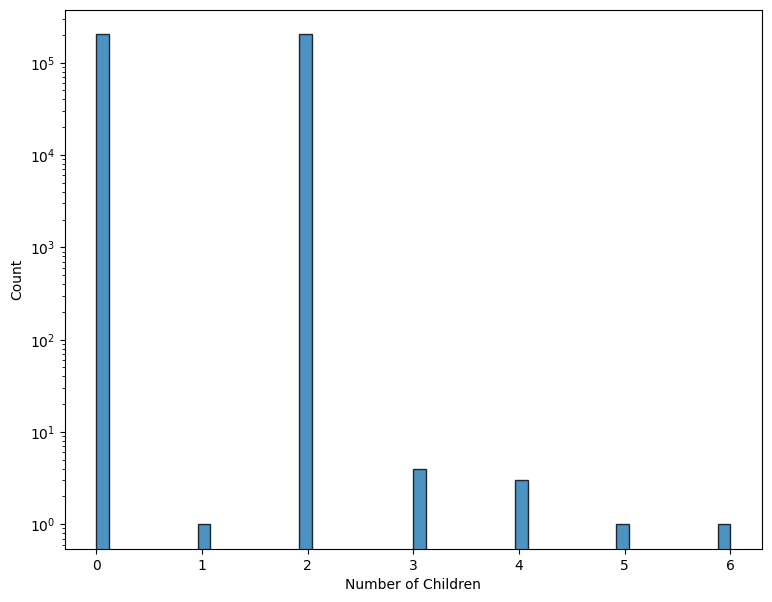

In [12]:
fig, ax = plot_n_children_distribution(find_n_children(t), log=True)
plt.show()

In [13]:
data_dir2 = os.path.join(os.environ.get("DATA"), "greengenes2/")

In [15]:
start = time.time()
t = pcms.tree.nwk2tree(os.path.join(data_dir2, "gg_22_10_otus/2022.10.phylogeny.id.nwk"))
print(f"Time to parse: {time.time() - start:0.3}")
print(f"Tree size: {t.n_nodes:,}")
print(f"Covariance matrix size: {t.n_nodes**2:,}")
print(f"Minimum sparsification: {1 - (2 * (t.find_epl() + 1) / (t.n_nodes**2) - 3 / t.n_nodes)}")

Time to parse: 16.7
Tree size: 22,090,657
Covariance matrix size: 487,997,126,691,649
Minimum sparsification: 0.9999933560489649


In [16]:
print("is_planted: ", t.find_is_planted())
print("root degree: ", t.find_children(t.find_root()).size)

is_planted:  True
root degree:  1


In [ ]:
n_children = find_n_children(t)

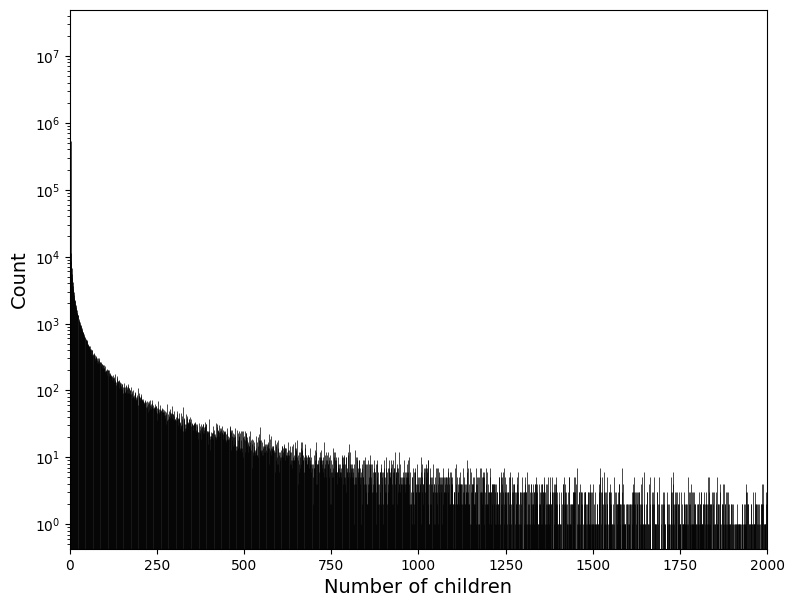

In [18]:
fig, ax = plt.subplots(figsize=(9,7))

counts, bin_edges = np.histogram(n_children, bins=np.max(n_children))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot each bin as an individual vertical line
for bin_center, count in zip(bin_centers, counts):
    ax.vlines(bin_center, ymin=0, ymax=count, colors='black', linewidth=0.5)

# Rescale axes
# ax.set_xscale('symlog', linthresh=1e3)
ax.set_xlim([0,2e3])
ax.set_yscale('log')

# Labels and formatting
ax.set_xlabel("Number of children", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

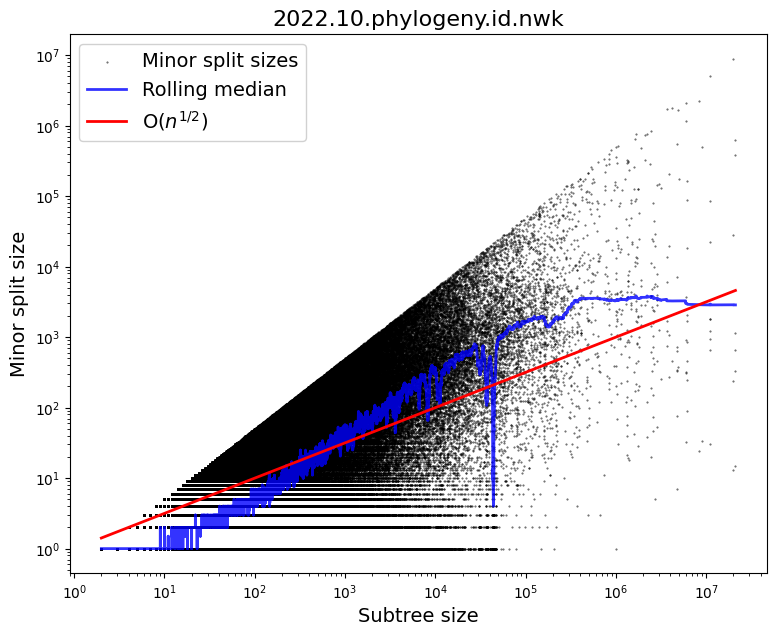

In [19]:
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("2022.10.phylogeny.id.nwk", fontsize=16)
plt.show()

### Minor split size of a Greengenes tree

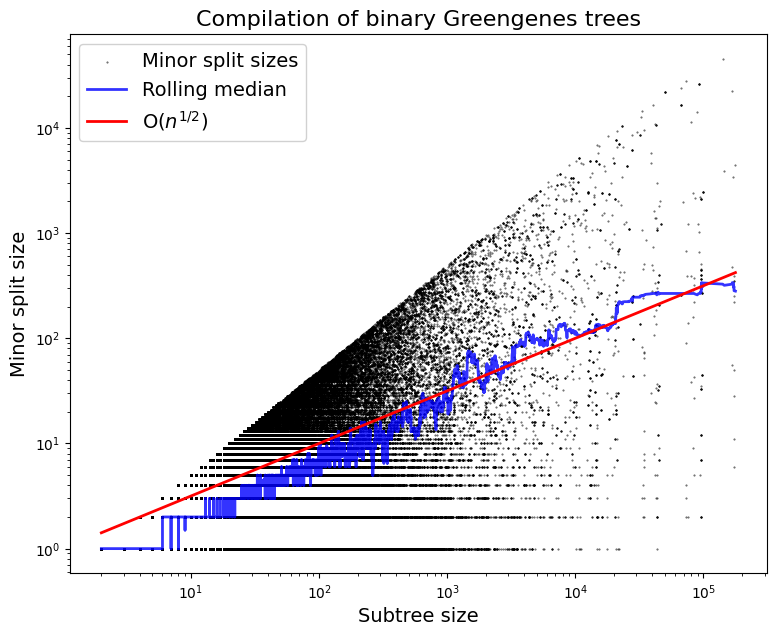

In [28]:
subtree_sizes = []
minor_split_sizes = []
for filepath in nwk_filepaths_binary:
    t = pcms.tree.nwk2tree(filepath)
    a, b = find_minor_split_sizes(t)
    subtree_sizes += a
    minor_split_sizes += b
fig, ax = plot_minor_split_sizes(subtree_sizes, minor_split_sizes, sample_median=True)
ax.set_title("Compilation of binary Greengenes trees", fontsize=16)
plt.show()

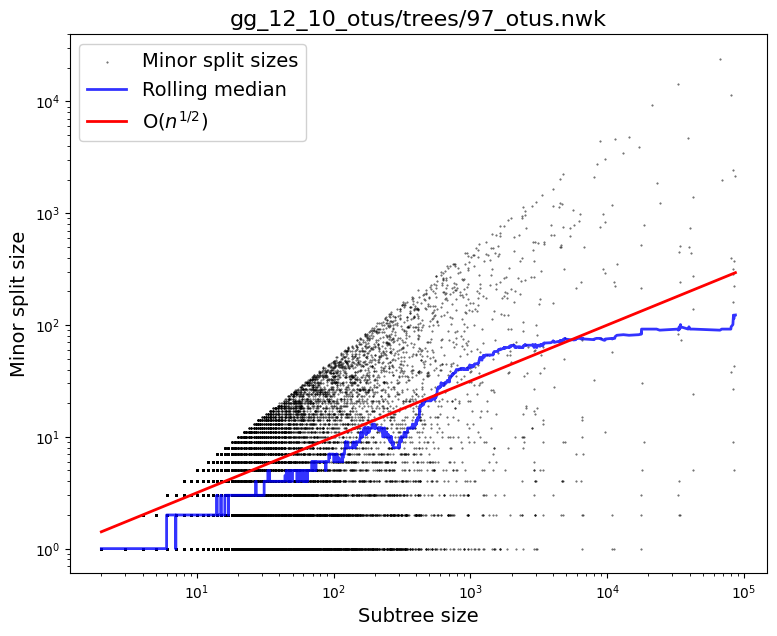

In [29]:
t = pcms.tree.nwk2tree(os.path.join(data_dir, "gg_12_10_otus/trees/97_otus.nwk"))
n_leaves = t.n_nodes//2
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("gg_12_10_otus/trees/97_otus.nwk", fontsize=16)
plt.show()

### Minor split size of a critical beta-splitting tree

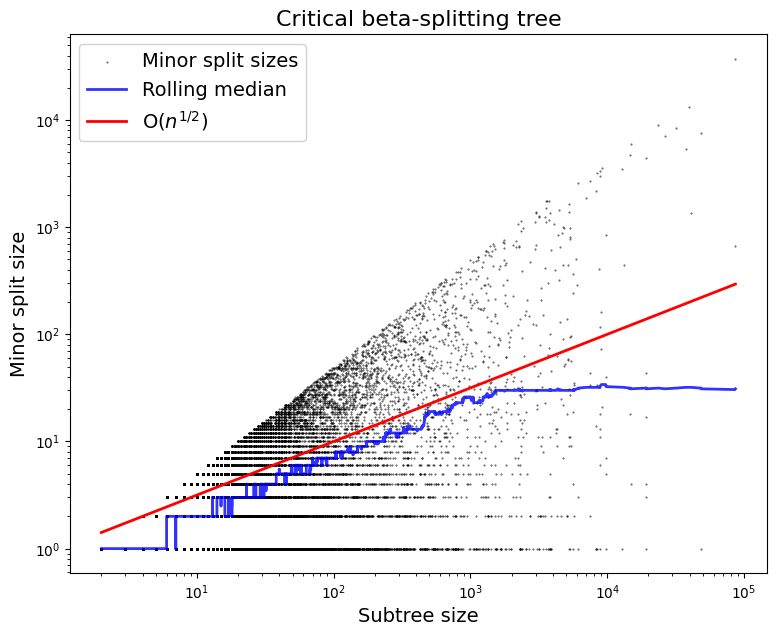

In [30]:
t = pcms.tree.cbst(n_leaves=n_leaves)
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("Critical beta-splitting tree", fontsize=16)
plt.show()

### Minor split size of a uniform tree

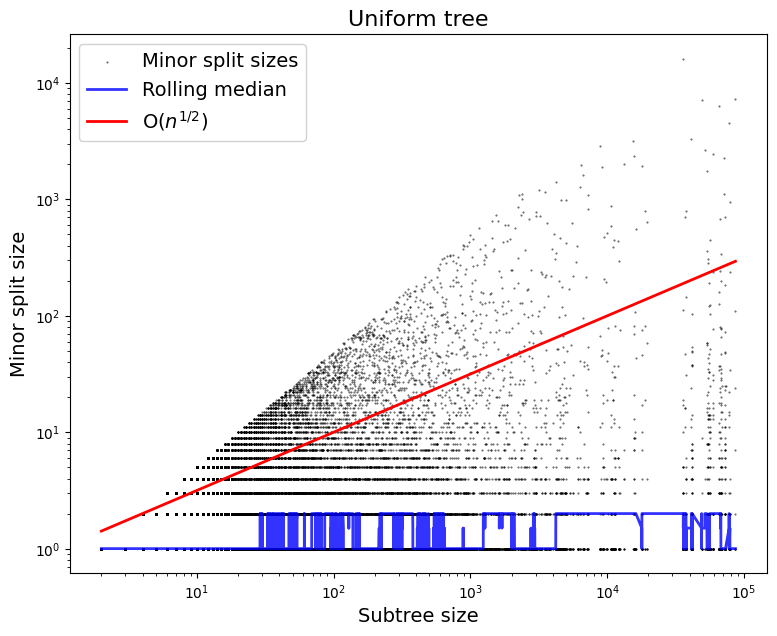

In [31]:
t = pcms.tree.remy(n_leaves=n_leaves)
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("Uniform tree", fontsize=16)
plt.show()